In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_single(path):
    with open(path) as f:
        lines = f.readlines()[5:]    
        v = np.zeros((len(lines), 2))
    
        for i in range(len(lines)):
            split = lines[i].split('\t')
            v[i,0] = float(split[0])
            v[i,1] = float(split[1])
    
        return v
    
def load_all(path):
    vals_list = []
    f_list = [f for f in os.listdir(path) if f.endswith('.txt')]
    
    if path.endswith(os.path.sep):
        new_path = path
    else:
        new_path = path+os.path.sep
    
    for f in f_list:
        vals_list.append(load_single(new_path+f))
        
    return vals_list
    
    
def plot_single(v):
    plt.plot(v[:,0],v[:,1])
    plt.plot([v[0,0], v[-1,0]], [2, 2])
    plt.show()
    
def plot_all(ref, v_list, factor = 1):
    plt.figure()
    plt.plot(ref[:,0],ref[:,1])
    plt.plot([ref[0,0], ref[-1,0]], [2, 2])
    for v in v_list:
        plt.plot(v[:,0],factor*v[:,1])
    plt.show()
    
def plot_wide(ref, v_list, factor = 1):
    plt.figure(figsize=(15, 3))
    plt.plot(ref[:,0],ref[:,1])
    plt.plot([ref[0,0], ref[-1,0]], [2, 2])
    for v in v_list:
        plt.plot(v[:,0],factor*v[:,1])
    plt.show()
    
def plot_multichannel(ref, v_list, factor = 1):
    plt.figure()
    plt.plot(ref[:,0],ref[:,1])
    plt.plot([ref[0,0], ref[-1,0]], [2, 2])
    for ch in v_list:
        for v in ch:
            plt.plot(v[:,0],factor*v[:,1])
    plt.show()
    
def average_last(v_list, window = 50):
    av = 0
    n = len(v_list)
    for v in v_list:
        av += np.mean(v[-window:,1]) / n
        
    return av

def get_delays(v_list, threshold = 2, factor = 1, inverted = False):
    ds = []
    
    for v in v_list:
        if inverted:
            v_inv = v[::-1,:]
            t = v_inv[get_delay_index_inverted(v, threshold, factor), 0]
        else:
            t = v[get_delay_index(v, threshold, factor), 0]
              
        ds.append(t)
    
    return np.array(ds)
    
def get_delay_index(v, threshold = 2, factor = 1):
    return np.argmax(factor*v[:,1] > threshold)

def get_delay_index_inverted(v, threshold = 2, factor = 1):
    return np.argmax(factor*v[::-1,1] <= threshold)+1


## Figure 2a: pulsing delay

In [3]:
# load data
cam = load_single('figure2a/C1camera00000.txt')
all_vals = load_all('figure2a/ch2')
print(f'Number of measurements: {len(all_vals)}')

Number of measurements: 1024


In [4]:
# verify that the camera thresholding was at 2v
t0 = cam[np.argmax(cam[:,1] >= 2), 0]
t1 = cam[np.argmax(cam[:,1] >= 2)+1, 0]
print(t0, t1)

-8.3363e-11 3.16637e-10


In [5]:
# compute delay
delays = get_delays(all_vals)*1_000_000_000  # to ns
print(f'Delay {np.mean(delays)} +/- {np.std(delays)} ns')
print(f'Min delay {np.min(delays)}, Max delay {np.max(delays)}, Median {np.median(delays)}')

Delay 61.71290810546875 +/- 3.125737297860624 ns
Min delay 55.314299999999996, Max delay 67.4598, Median 61.59445


448


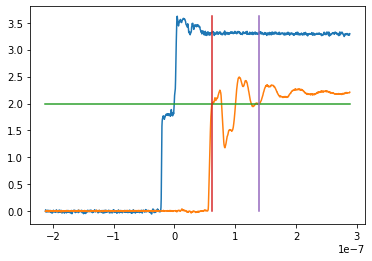

Delay 138.6801015625 +/- 2.8194907361382544 ns
Min delay 133.208, Max delay 143.914, Median 138.66449999999998


In [6]:
# choosing the first time it crosses the threshold or the last time makes a difference in the quantification
def plot_vertical(ref, val, vertical):
    plt.plot(ref[:,0],ref[:,1])
    plt.plot(val[:,0],val[:,1])
    plt.plot([val[0,0], val[-1,0]], [2, 2])
    
    for vert in vertical:
        plt.plot([vert, vert], [0, max(np.max(ref), np.max(val))])
    plt.show()


i_med = np.argmin(abs(delays - np.median(delays)))
print(i_med)
val = all_vals[i_med]

delay0 = np.median(delays) / 1_000_000_000

val1 = val[::-1,:]
delay1 = val1[get_delay_index_inverted(val), 0]

plot_vertical(cam, val, [delay0, delay1])    

# compute delay
delays_inv = get_delays(all_vals, inverted = True)*1_000_000_000  # to ns
print(f'Delay {np.mean(delays_inv)} +/- {np.std(delays_inv)} ns')
print(f'Min delay {np.min(delays_inv)}, Max delay {np.max(delays_inv)}, Median {np.median(delays_inv)}')

1 1 0
[888, 35, 448]


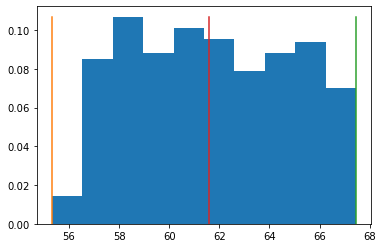

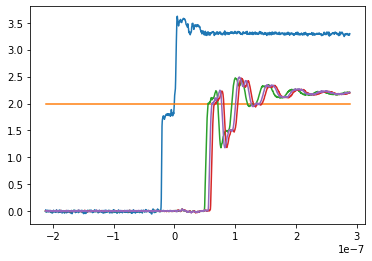

In [7]:
def plot_histo(vals, vertical):
    y, x, _ = plt.hist(vals, density=True)
    
    for v in vertical:
        plt.plot([v, v], [0, max(y)])
    
    plt.show()

# get indices of min, max and median
print(np.sum(delays == np.min(delays)), np.sum(delays == np.max(delays)), np.sum(delays == np.median(delays)))

i_s = [np.argmax(delays == np.min(delays)),
       np.argmax(delays == np.max(delays)),
       np.argmin(abs(delays - np.median(delays)))]
vals = [all_vals[i] for i in i_s]
print(i_s)

plot_histo(delays, delays[i_s]) # check that the median, min and max curves are really so

plot_all(cam, vals)

## Figure 2b: pulse length accuracy

In [8]:
# load data
cam = load_single('figure2b/C1ch1_cam00000.txt')
ch2 = load_all('figure2b/ch2')
ch3 = load_all('figure2b/ch3')
ch4 = load_all('figure2b/ch4')

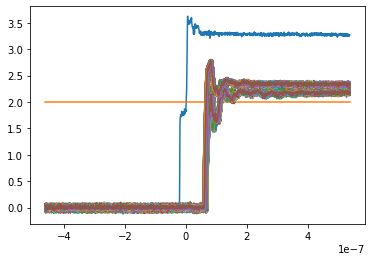

In [9]:
# show data
plot_multichannel(cam, [ch2, ch3, ch4])

### Here we want to see the pulse length 1, 2 and 3 us. Which is not possible with the current plot.

## Figure 2c: illustrate sequence

In [10]:
# load data
cam = load_single('figure2c/oneScreenshot_5s/C1ch100000.txt')
ch2 = load_single('figure2c/oneScreenshot_5s/C2ch200000.txt')
ch3 = load_single('figure2c/oneScreenshot_5s/C3ch300000.txt')
ch4 = load_single('figure2c/oneScreenshot_5s/C4ch400000.txt')

In [11]:
def count_frames(ref):
    
    counter = 0
    for i in range(len(ref)-1):
        if ref[i,1] <= 2 < ref[i+1,1]:
            counter += 1
            
    return counter

def find_rising(ref, n = 1):
    counter = 0
    for i in range(len(ref)-1):
        if ref[i,1] <= 2 < ref[i+1,1]:
            counter += 1
            if counter == n:
                return i 
        
    return -1

def find_falling(ref, n = 1):
    counter = 0
    for i in range(len(ref)-1):
        if ref[i,1] >= 2 > ref[i+1,1]:
            counter += 1
            if counter == n:
                return i 
        
    return -1


In [12]:
n_frames = count_frames(cam)
print(f'Total number of frames: {n_frames}')
print(f'Number of full sequences: {int(n_frames / 16)}')

Total number of frames: 171
Number of full sequences: 10


In [13]:
i_fr = find_rising(cam)
i_sr = find_rising(cam, 2)
i_ff = find_falling(cam)

offset = int( (i_fr-i_ff) / 2.) 
length_frame = i_sr-i_fr

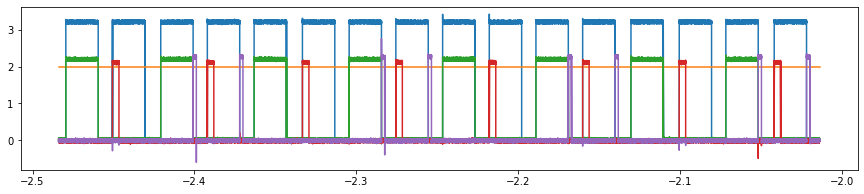

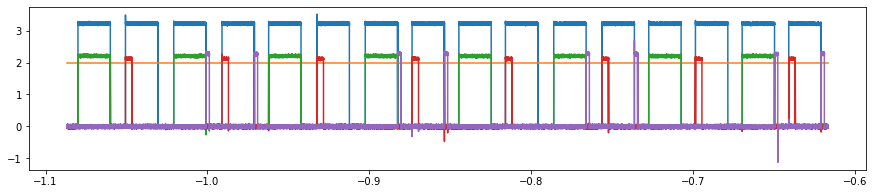

In [14]:
first_pt = i_ff+offset
last_pt = first_pt + 16*length_frame +2*offset
plot_wide(cam[first_pt:last_pt,:], 
          [ch2[first_pt:last_pt,:], 
           ch3[first_pt:last_pt,:], 
           ch4[first_pt:last_pt,:]])

first_pt = i_ff+4*offset+3*16*length_frame
last_pt = first_pt + 16*length_frame +2*offset
plot_wide(cam[first_pt:last_pt,:], 
          [ch2[first_pt:last_pt,:], 
           ch3[first_pt:last_pt,:], 
           ch4[first_pt:last_pt,:]])

In [15]:
def plot_wide_offset(ref, v_list, factor = 1):
    plt.figure(figsize=(15, 12))
    
    counter = len(v_list)
    fac = 3
    plt.plot(ref[:,0],counter*fac+ref[:,1])
    plt.plot([ref[0,0], ref[-1,0]], [counter*fac+2, counter*fac+2])
    for v in v_list:
        counter -= 1
        plt.plot([ref[0,0], ref[-1,0]], [counter*fac+2, counter*fac+2])
        plt.plot(v[:,0],counter*fac+factor*v[:,1])
    plt.show()

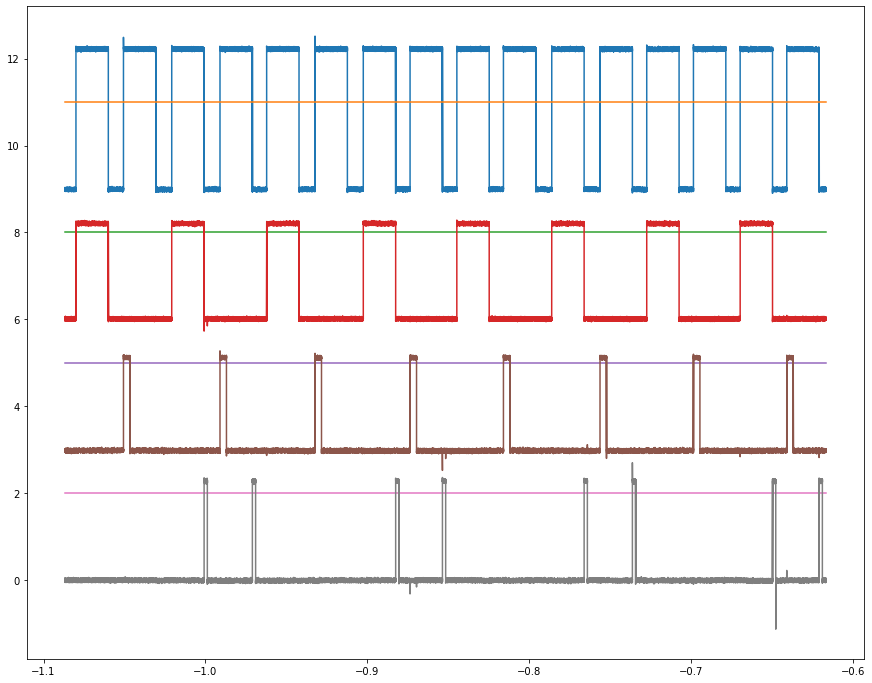

In [16]:
plot_wide_offset(cam[first_pt:last_pt,:], 
          [ch2[first_pt:last_pt,:], 
           ch3[first_pt:last_pt,:], 
           ch4[first_pt:last_pt,:]])

## Figure active trigger: illustrate the different parameters

In [17]:
# load data
ch1 = load_single('figure_active_trigger/complete/C1ch100000.txt')
ch2 = load_single('figure_active_trigger/complete/C2ch200000.txt')
ch3 = load_single('figure_active_trigger/complete/C3ch300000.txt')
ch4 = load_single('figure_active_trigger/complete/C4ch400000.txt')

In [18]:
n_frames = count_frames(ch1)
print(f'Total number of frames: {n_frames}')
print(f'Number of full sequences: {int(n_frames / 16)}')

Total number of frames: 81
Number of full sequences: 5


In [19]:
i_fr = find_rising(ch2)
i_sr = find_rising(ch2, 2)
i_ff = find_falling(ch2)

offset = int( (i_ff-i_fr) / 2.) 
length_frame = i_sr-i_fr

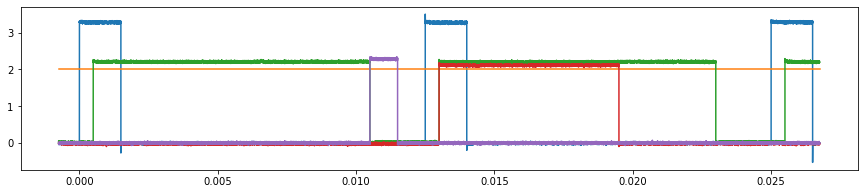

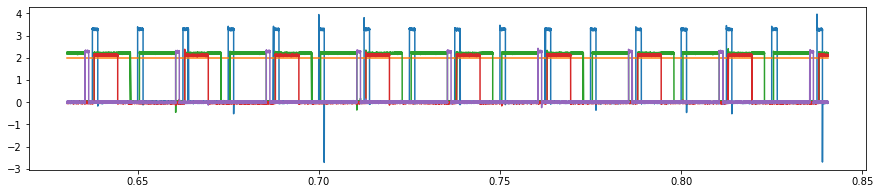

In [20]:
first_pt = i_fr-int(offset/4)
last_pt = i_sr+length_frame+int(offset/4)
plot_wide(ch1[first_pt:last_pt,:], 
          [ch2[first_pt:last_pt,:], 
           ch3[first_pt:last_pt,:], 
           ch4[first_pt:last_pt,:]])

first_pt = i_ff+4*offset+3*16*length_frame
last_pt = first_pt + 16*length_frame +2*offset
plot_wide(ch1[first_pt:last_pt,:], 
          [ch2[first_pt:last_pt,:], 
           ch3[first_pt:last_pt,:], 
           ch4[first_pt:last_pt,:]])

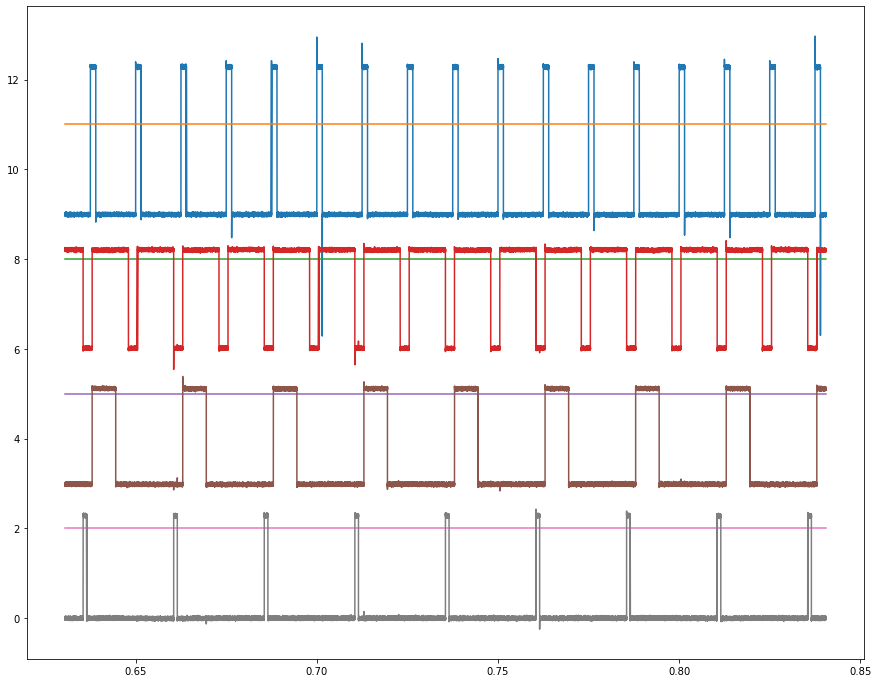

In [21]:
plot_wide_offset(ch1[first_pt:last_pt,:], 
          [ch2[first_pt:last_pt,:], 
           ch3[first_pt:last_pt,:], 
           ch4[first_pt:last_pt,:]])

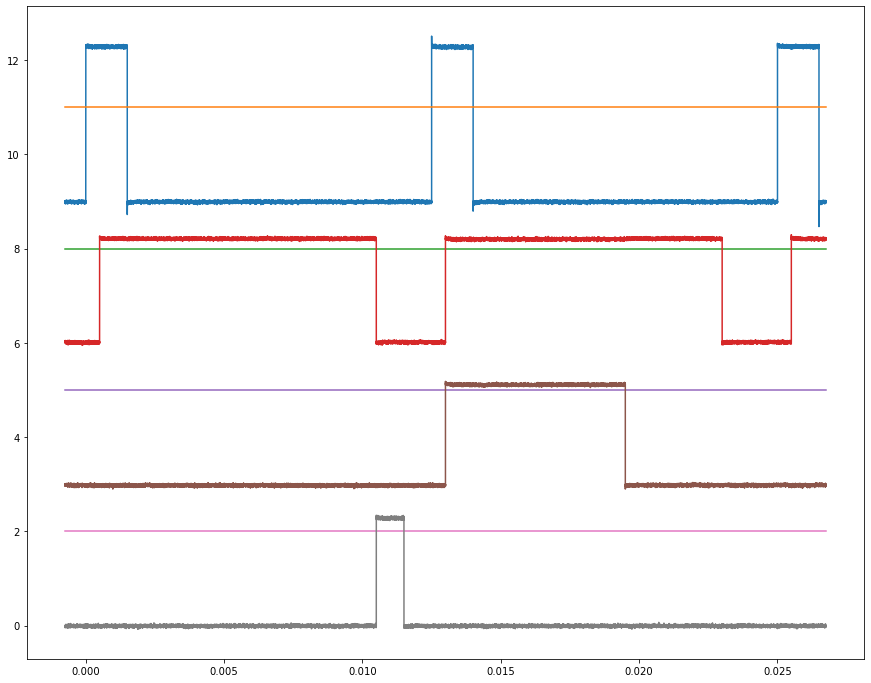

In [22]:
first_pt = i_fr-int(offset/4)
last_pt = i_sr+length_frame+int(offset/4)
plot_wide_offset(ch1[first_pt:last_pt,:], 
          [ch2[first_pt:last_pt,:], 
           ch3[first_pt:last_pt,:], 
           ch4[first_pt:last_pt,:]])

In [23]:
# compute average delay
def get_camera_delay(camera, laser):

    t0 = []
    t1 = []
    t0_f = []
    t1_f = []
    for i in range(len(camera)-1):
        if camera[i,1] <= 2 < camera[i+1,1]:
                t0.append(camera[i, 0])
        
        if laser[i,1] <= 2 < laser[i+1,1]:
                t1.append(laser[i, 0])
                
        if camera[i,1] >= 2 > camera[i+1,1]:
                t0_f.append(laser[i, 0])
                
        if laser[i,1] >= 2 > laser[i+1,1]:
                t1_f.append(laser[i, 0])
        
    assert len(t0) == len(t1)
    assert len(t0) == len(t0_f)
    assert len(t1) == len(t1_f)
        
    delays = np.array([t1[i]-t0[i] for i in range(len(t1))])*1_000_000
    expo = np.array([t1_f[i]-t1[i] for i in range(len(t1))])*1_000_000
    pulse = np.array([t0_f[i]-t0[i] for i in range(len(t0))])*1_000_000
    period = np.array([t0[i+1]-t0[i] for i in range(len(t0)-1)])*1_000_000
        
    return delays, expo, pulse, period

t_delays, t_expo, t_pulse, t_period = get_camera_delay(ch1, ch2)

print(f'Delay {np.mean(t_delays)} +/- {np.std(t_delays)} us')
print(f'Exposure {np.mean(t_expo)} +/- {np.std(t_expo)} us')
print(f'Pulse {np.mean(t_pulse)} +/- {np.std(t_pulse)} us')
print(f'Period {np.mean(t_period)} +/- {np.std(t_period)} us')

Delay 500.0599888981664 +/- 0.15124394551111128 us
Exposure 9999.876544476545 +/- 0.18477405094373325 us
Pulse 1499.9612234611272 +/- 0.10476405620989808 us
Period 12499.890000291887 +/- 0.17860589076942557 us


## Figure active a: measure delay in pulsing

In [24]:
# load data
cam = load_single('figure_active_a_again/C1_00000.txt')
all_vals = load_all('figure_active_a_again/ch2')
print(f'Number of measurements: {len(all_vals)}')

Number of measurements: 549


In [25]:
# thresholding not at 2V?
t0 = cam[np.argmax(cam[:,1] >= 2), 0]
t1 = cam[np.argmax(cam[:,1] >= 2)+1, 0]
print(t0, t1)

-1.13084e-09 -7.30843e-10


In [26]:
# compute delay
delays = get_delays(all_vals)*1_000_000_000  # to ns
print(f'Delay {np.mean(delays)} +/- {np.std(delays)} ns')
print(f'Min delay {np.min(delays)}, Max delay {np.max(delays)}, Median {np.median(delays)}')

Delay 56.549647540983614 +/- 0.5187502116911903 ns
Min delay 55.3426, Max delay 57.5471, Median 56.7223


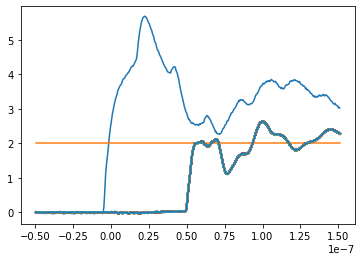

In [27]:
plot_all(cam, all_vals)

### We can't say anything with this figure because the signal is not stable yet, so we can't measure the delay

## Figure active b: measure pulse widths

In [28]:
# load data
cam = load_single('figure_active_b_again/C2_00000.txt')
ch2 = load_all('figure_active_b_again/ch2')
ch3 = load_all('figure_active_b_again/ch3')
ch4 = load_all('figure_active_b_again/ch4')

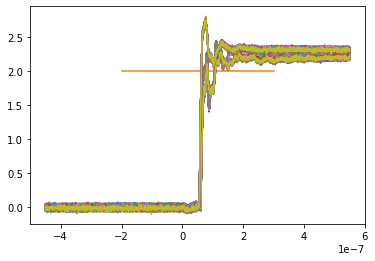

In [29]:
# show data
plot_multichannel(cam, [ch2, ch3, ch4])

### Here we want to see the pulse length 1, 2 and 3 us. Which is not possible with the current plot.